# Modeling

### Import Libaries

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import time

from scipy.stats import randint
from sklearn import __version__ as sklearn_version
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, f1_score, mean_absolute_error,
                             mean_squared_error, precision_score, r2_score, recall_score, roc_curve,roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, cross_val_score,
                                     cross_validate, learning_curve, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


### Load Data

In [2]:
datafilepath = "../data/interim/train_test_split.pkl"

with open(datafilepath, 'rb') as file:
    X,y,X_train, X_test, y_train, y_test = pickle.load(file)

In [3]:
X_train

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,Cluster,MaritalStatus_No,...,CityCode_SEW,CityCode_SFR,CityCode_SFU,CityCode_SHE,CityCode_SLC,CityCode_SLU,CityCode_STL,CityCode_VAH,ChildrenInHH_No,ChildrenInHH_Yes
26793,30.00,129.0,30.0,0.00,0.0,0.0,0.0,9,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16987,57.66,600.0,37.0,0.50,58.0,0.0,1.0,4,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30844,117.13,1204.0,60.0,1.24,204.0,0.3,0.0,9,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48733,12.18,308.0,10.0,0.99,0.0,1.4,0.0,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
47016,38.99,275.0,45.0,0.00,0.0,0.0,0.0,6,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11288,8.75,154.0,45.0,0.99,0.0,0.0,2.0,8,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44747,58.35,69.0,70.0,0.00,4.0,3.0,0.7,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38172,55.23,693.0,62.0,1.24,0.0,0.0,1.3,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
860,181.75,1578.0,110.0,0.00,232.0,0.5,2.0,4,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Initiation

In [4]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

0.28931310804518834

In [5]:
#Calculate the medium of `y_train`
X_defaults_median = X_train.median()
X_defaults_median

MonthlyRevenue            48.46
MonthlyMinutes           366.00
TotalRecurringCharge      45.00
DirectorAssistedCalls      0.25
OverageMinutes             3.00
                          ...  
CityCode_SLU               0.00
CityCode_STL               0.00
CityCode_VAH               0.00
ChildrenInHH_No            1.00
ChildrenInHH_Yes           0.00
Length: 79, dtype: float64

#### Impute NaN Data

In [6]:
# Check for NaN values
print("NaN values in X_test:", X_test.isna().sum().sum())

# Replace NaN values with the mean (you can choose other methods)
X_test = X_test.fillna(X_test.mean())

# Check for infinity values
print("Infinity values in X_test:", np.isinf(X_test).sum().sum())

# Replace infinity values
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.mean())

NaN values in X_test: 0
Infinity values in X_test: 0


#### Normalize or Scale your data

In [7]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_test

array([[-1.02156899, -0.9962869 , -1.38461883, ..., -0.0313235 ,
         0.56776671, -0.56776671],
       [-1.05258511, -0.39949298, -1.55411025, ..., -0.0313235 ,
        -1.76128677,  1.76128677],
       [ 0.4807743 ,  0.35885344,  0.56453254, ..., -0.0313235 ,
         0.56776671, -0.56776671],
       ...,
       [-0.23281184, -0.77201402,  1.41198965, ..., -0.0313235 ,
        -1.76128677,  1.76128677],
       [ 0.45255825,  0.79409487, -1.55411025, ..., -0.0313235 ,
        -1.76128677,  1.76128677],
       [ 1.99862565,  0.93283995,  0.56453254, ..., -0.0313235 ,
         0.56776671, -0.56776671]])

### Models

#### Initialize models

In [8]:

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "Neural Network": MLPClassifier(),
    "KNN": KNeighborsClassifier(),
    "xgboost": XGBClassifier()
}

#### Train Models

In [9]:

model_performance = {}


In [10]:


# Loop through models
for name, model in models.items():
    start_time = time.time()
    current_time = datetime.now()
    print('Started at: ', current_time.strftime("%H:%M:%S"))
    print('Model Name: ',name)
    print('----------------------------------')
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    roc_auc = roc_auc_score(y_test, y_scores)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    model_performance[name] = {
        "Accuracy": accuracy,
        "Classification Report": class_report,
        "CV Score": cv_scores.mean(),
        "ROC AUC": roc_auc
    }
    
    print('----------------------------------')
    elapsed_time = (time.time() - start_time) / 60
    print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  11:11:39
Model Name:  Decision Tree
----------------------------------
----------------------------------
Elapsed time: 0.07 minutes
Started at:  11:11:44
Model Name:  Random Forest
----------------------------------
----------------------------------
Elapsed time: 0.80 minutes
Started at:  11:12:32
Model Name:  Gradient Boosting
----------------------------------
----------------------------------
Elapsed time: 0.89 minutes
Started at:  11:13:25
Model Name:  Neural Network
----------------------------------
----------------------------------
Elapsed time: 0.63 minutes
Started at:  11:14:03
Model Name:  KNN
----------------------------------
----------------------------------
Elapsed time: 1.36 minutes
Started at:  11:15:25
Model Name:  xgboost
----------------------------------
----------------------------------
Elapsed time: 0.07 minutes


##### Models Comparison

In [11]:
#model_performance

In [12]:
for model_name, performance in model_performance.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {performance['Accuracy']}")
    print("Classification Report:")
    print(performance['Classification Report'])
    print("cv scores:")
    print(performance['CV Score'])
    print("ROC AUC score:")
    print(performance['ROC AUC'])
    print("-" * 80)  # Separator for readability

Model: Decision Tree
Accuracy: 0.6648696334052147
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      7315
           1       0.27      0.11      0.16      2887

    accuracy                           0.66     10202
   macro avg       0.49      0.50      0.47     10202
weighted avg       0.59      0.66      0.61     10202

cv scores:
0.600011701671525
ROC AUC score:
0.49728918921670456
--------------------------------------------------------------------------------
Model: Random Forest
Accuracy: 0.4363850225445991
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.34      0.46      7315
           1       0.29      0.68      0.41      2887

    accuracy                           0.44     10202
   macro avg       0.51      0.51      0.43     10202
weighted avg       0.61      0.44      0.45     10202

cv scores:
0.7047972452393425
ROC AUC score:
0.52022404

In [14]:
# Extracting the relevant metrics for DataFrame creation
models, accuracies, precisions, recalls, f1_scores , roc_auc  = [], [], [], [], [] ,[]

for model, metrics in model_performance.items():
    models.append(model)
    
    accuracies.append(metrics['Accuracy'])
    lines = metrics['Classification Report'].split('\n')
    summary_metrics = lines[-2].split()
    precisions.append(float(summary_metrics[2]))
    recalls.append(float(summary_metrics[3]))
    f1_scores.append(float(summary_metrics[4]))
    roc_auc.append(metrics['ROC AUC'])

# Creating the DataFrame
df_report = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores,
    'ROCAUC-Score': f1_scores,
   
})

df_report

,Model,Accuracy,Precision,Recall,F1-Score,ROCAUC-Score
0,Decision Tree,0.664870,0.59,0.66,0.61,0.61
1,Random Forest,0.436385,0.61,0.44,0.45,0.45
2,Gradient Boosting,0.676534,0.60,0.68,0.62,0.62
3,Neural Network,0.527642,0.61,0.53,0.55,0.55
4,KNN,0.592531,0.60,0.59,0.60,0.60
5,xgboost,0.323564,0.62,0.32,0.23,0.23


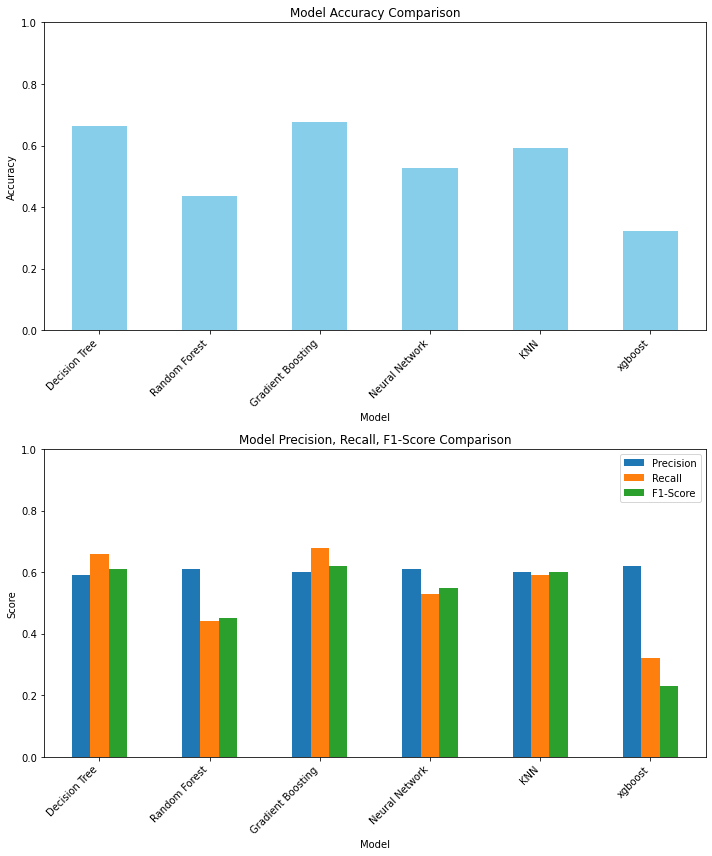

In [15]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Accuracy Plot
df_report.plot(kind='bar', x='Model', y='Accuracy', ax=axs[0], color='skyblue', legend=False)
axs[0].set_title('Model Accuracy Comparison')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

# Precision, Recall, F1-Score Plot
df_report.plot(kind='bar', x='Model', y=['Precision', 'Recall', 'F1-Score'], ax=axs[1])
axs[1].set_title('Model Precision, Recall, F1-Score Comparison')
axs[1].set_ylabel('Score')
axs[1].set_ylim(0, 1)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

<b>The Gradient Boosting model</b> is the best performer in terms of accuracy and F1-Score, making it a strong candidate for selection. It shows a good balance between precision and recall, especially for class 0 (the majority class).

##### Lets see cross validation comparison

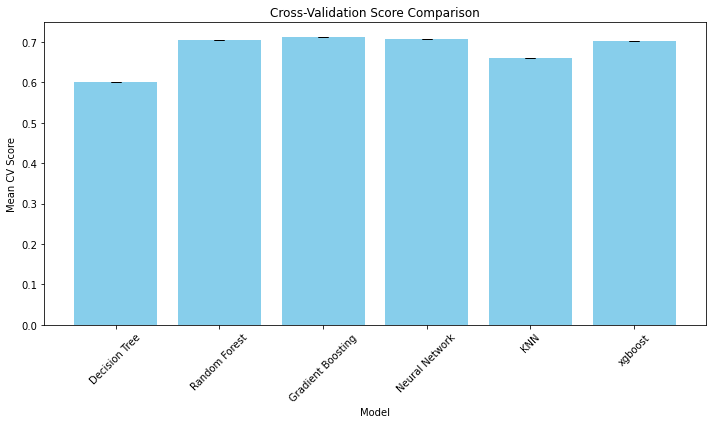

[('Decision Tree', 0.600011701671525, 0.0),
 ('Random Forest', 0.7047972452393425, 0.0),
 ('Gradient Boosting', 0.7130505538922509, 0.0),
 ('Neural Network', 0.7085809842821895, 0.0),
 ('KNN', 0.6600209211819492, 0.0),
 ('xgboost', 0.7038757016126418, 0.0)]

In [16]:
model_names = list(model_performance.keys())
cv_scores = [model_performance[model]['CV Score'] for model in model_names]

# Calculate mean and standard deviation of cross-validation scores for each model
cv_means = [np.mean(scores) for scores in cv_scores]
cv_stds = [np.std(scores) for scores in cv_scores]

plt.figure(figsize=(10, 6))
plt.bar(model_names, cv_means, yerr=cv_stds, capsize=5, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean CV Score')
plt.title('Cross-Validation Score Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


list(zip(model_names, cv_means, cv_stds))

Again,<b>Gradient Boosting </b> has Highest performance & consistency with mean score 0.713,and  is the most suitable model for this dataset, showing the best average cross-validation score and consistency. It is closely followed by Random Forest and XGBoost, which also exhibit strong performance.

### Final Modeling

In [17]:
final_model = GradientBoostingClassifier(random_state=0)

# Adding model metadata
final_model.version = '1.0'
final_model.pandas_version = pd.__version__
final_model.numpy_version = np.__version__
final_model.sklearn_version = sklearn_version
final_model.X_columns = [col for col in X_train.columns] 
final_model.build_datetime = datetime.now()

start_time = time.time()
current_time = datetime.now()
print('Started at: ', current_time.strftime("%H:%M:%S"))
print('Model Name: ',name)
print('----------------------------------')
    

final_model.fit(np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)))
final_pred = final_model.predict(scaler.fit_transform(X))



cv_scores = cross_val_score(final_model, np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)), cv=5)
print(f'CV Scores: {cv_scores}')
print(f'Average CV Score: {cv_scores.mean()}')

final_model.cv_scores = cv_scores
final_model.mean_cv_score = cv_scores.mean()

print(final_model.cv_scores)
print(final_model.mean_cv_score)

print('----------------------------------')
elapsed_time = (time.time() - start_time) / 60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  11:25:42
Model Name:  xgboost
----------------------------------
CV Scores: [0.71338953 0.71338953 0.71397765 0.71338953 0.71208705]
Average CV Score: 0.7132466592246676
[0.71338953 0.71338953 0.71397765 0.71338953 0.71208705]
0.7132466592246676
----------------------------------
Elapsed time: 1.29 minutes


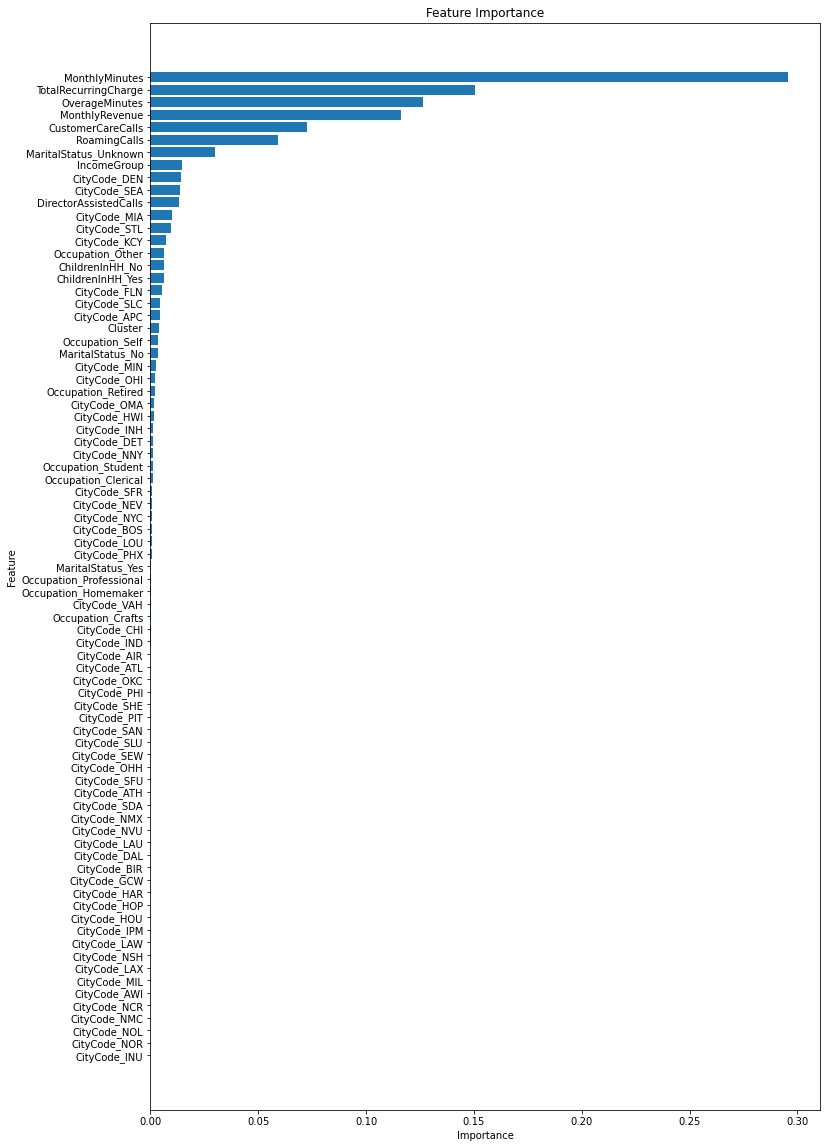

In [18]:
feature_importance = final_model.feature_importances_

features_df = pd.DataFrame({
    'Feature': final_model.X_columns,
    'Importance': feature_importance
})

features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 20))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [19]:
df_pred =X.copy()
df_pred['Churn_Predicted'] = final_pred
df_pred['Churn'] = y

In [20]:
df_pred[df_pred['Churn']==1]

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,Cluster,MaritalStatus_No,...,CityCode_SFU,CityCode_SHE,CityCode_SLC,CityCode_SLU,CityCode_STL,CityCode_VAH,ChildrenInHH_No,ChildrenInHH_Yes,Churn_Predicted,Churn
0,24.00,219.0,22.0,0.25,0.0,0.0,0.0,4,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
1,16.99,10.0,17.0,0.00,0.0,0.0,0.0,5,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
4,17.14,0.0,17.0,0.00,0.0,0.0,0.0,9,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
15,172.44,1978.0,100.0,0.00,362.0,0.0,0.3,6,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
18,24.49,42.0,17.0,0.00,10.0,0.0,0.0,9,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51031,33.63,28.0,30.0,0.00,0.0,0.0,0.0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
51033,38.34,320.0,30.0,0.99,21.0,0.0,1.3,6,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
51041,117.49,384.0,30.0,0.00,250.0,0.0,0.0,2,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
51042,48.46,366.0,45.0,0.25,3.0,0.0,0.0,6,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1


##### Save Model File

In [21]:
save_modelfilepath = "../models/final_model.pkl"
with open(save_modelfilepath, 'wb') as file:
    pickle.dump([final_model], file)

In [22]:
preddata_filepath = "../data/processed/pred_raw.csv"
df_pred.to_csv(preddata_filepath, index=False) 

### Post-Classification Analysis

Using churn probabilities from the classification model to further segment customers based on their risk of churning. This segmentation can help in strategizing targeted interventions for different risk groups. </br>
Low Risk (p < 0.3)</br>
Medium Risk (0.3 ≤ p < 0.7)</br>
High Risk (p ≥ 0.7)

In [23]:
# Get the churn probabilities for the whole data set
y_prob = final_model.predict_proba(X)[:, 1]  # Probability of class 1 (churn)
risk_segments = np.digitize(y_prob, bins=[0.3, 0.7])

X_risk = X.copy()
X_risk['ChurnProbability'] = y_prob
X_risk['RiskSegment'] = risk_segments

# Analyze the distribution of risk segments
risk_segment_distribution = X_risk['RiskSegment'].value_counts().sort_index()
risk_segment_distribution

0    32808
1    18199
2        2
Name: RiskSegment, dtype: int64